<h1 align="left">Digitl Image Processing - Final project</h1> 
<h2 align="center">Aviad Shurgi 311125371 & Avraham Raviv 204355390</h2> 

In [1]:
# Our project is about segmentation, and we are focusing cars segmentaion.
# Our Database is calles CamVid and taken from:
# http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/
# Our implementation based on: https://github.com/qubvel/segmentation_models.pytorch

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import random
import segmentation_models_pytorch as smp
import noise
from scipy.misc import toimage, imshow, imsave, imread
from PIL import Image
from IPython.display import display, HTML
import copy

In [3]:
# Create the data dir for folders
DATA_DIR = './DIP_data/CamVid/'

x_train_dir = os.path.join(DATA_DIR, 'train')
x_train_noise_dir = os.path.join(DATA_DIR, 'train_noise')
x_train_dcp_dir = os.path.join(DATA_DIR, 'train_dcp')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
x_valid_noise_dir = os.path.join(DATA_DIR, 'val_noise')
x_valid_dcp_dir = os.path.join(DATA_DIR, 'val_dcp')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
x_test_noise_dir = os.path.join(DATA_DIR, 'test_noise')
x_test_dcp_dir = os.path.join(DATA_DIR, 'test_dcp')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [4]:
# Helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [5]:
# The basic class for data
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

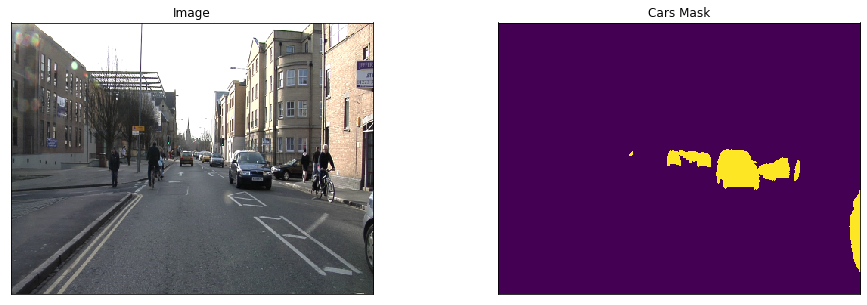

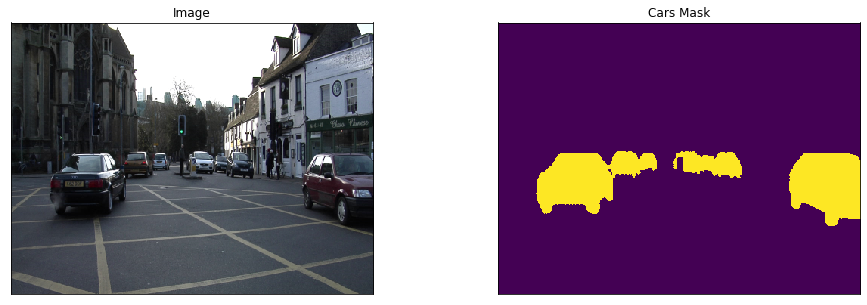

In [6]:
# First data class - train
dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])
for i in range(2):
    n = np.random.choice(len(dataset))
    image, mask = dataset[n] # get some sample
    visualize(
        image=image, 
        cars_mask=mask.squeeze(),
    )

<h2 align="left">Augmentations </h2>

In [7]:
# Create augmentation (not include the Perlin noise)
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

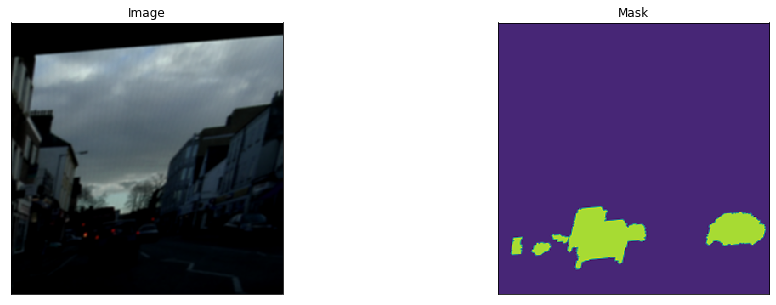

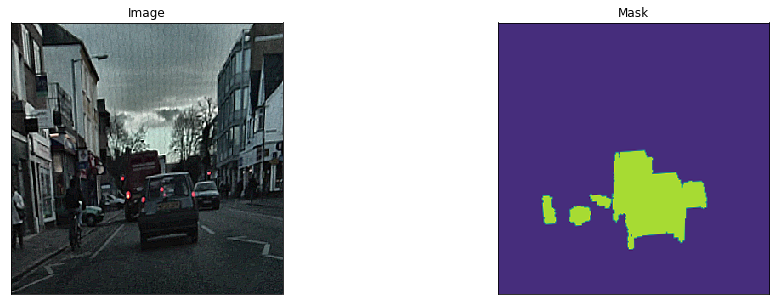

In [8]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['car'],
)

# Same image with different random transforms
idx = np.random.choice(len(augmented_dataset))
for i in range(2):
    image, mask = augmented_dataset[idx]
    visualize(image=image, mask=mask.squeeze(-1))

<h2 align="left">Perlin noise </h2>

In [9]:
# Helper function to create perlin noise
# Based on: https://stackoverflow.com/questions/60350598/perlin-noise-in-pythons-noise-library
def generate_perlin_noise(image_to_add):
    shape = image_to_add.shape[1], image_to_add.shape[0]
    scale = .5
    octaves = 6
    persistence = 0.5
    lacunarity = 2.0
    seed = np.random.randint(0,100)
    
    world = np.zeros(shape)

    # make coordinate grid on [0,1]^2
    x_idx = np.linspace(0, 1, shape[0])
    y_idx = np.linspace(0, 1, shape[1])
    world_x, world_y = np.meshgrid(x_idx, y_idx)

    # apply perlin noise, instead of np.vectorize, consider using itertools.starmap()
    world = np.vectorize(noise.pnoise2)(world_x/scale,
                            world_y/scale,
                            octaves=octaves,
                            persistence=persistence,
                            lacunarity=lacunarity,
                            repeatx=1024,
                            repeaty=1024,
                            base=seed)

    # here was the error: one needs to normalize the image first. Could be done without copying the array, though
    img = np.floor((world + .5) * 255).astype(np.uint8) # <- Normalize world first
    img = Image.fromarray(img, mode='L')
    return img

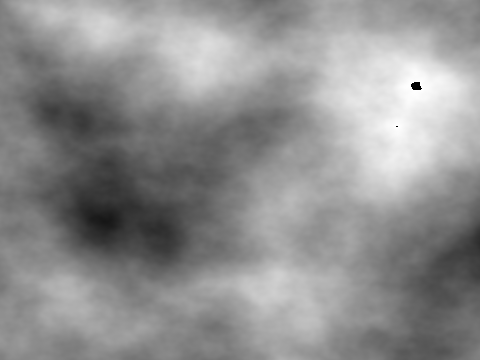

In [10]:
# An example of perlin noise
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))
generate_perlin_noise(dataset[0][0])

In [11]:
# Helper function to add perlin noise to image
def add_perlin_noise_to_image(image_to_add):
    img = generate_perlin_noise(image_to_add)
    img2=Image.fromarray(image_to_add)
    img2.paste(img, (0, 0), img)
    return(img2)

In [12]:
# Create augmentation data
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
           'tree', 'signsymbol', 'fence', 'car', 
           'pedestrian', 'bicyclist', 'unlabelled']
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES,
)

test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES,
)

In [13]:
# # Add perlin noise (generate seperate noise to each image)
# train_names = os.listdir(x_train_dir)
# i_train = 0
# for im_index in range(len(train_names)):
#     add_perlin_noise_to_image(dataset[i_train][0]).save(f"{x_train_noise_dir}/{train_names[i_train]}")
#     i_train = i_train + 1
    
# val_names = os.listdir(x_valid_dir)
# i_val = 0
# for im_index in range(len(val_names)):
#     add_perlin_noise_to_image(valid_dataset[i_val][0]).save(f"{x_valid_noise_dir}/{val_names[i_val]}")
#     i_val = i_val + 1

# test_names = os.listdir(x_test_dir)
# i_test = 0
# for im_index in range(len(test_names)):
#     add_perlin_noise_to_image(test_dataset[i_test][0]).save(f"{x_test_noise_dir}/{test_names[i_test]}")
#     i_test = i_test + 1

In [14]:
# Create noising dataset (dataset of perlin noise's images)
noise_dataset = Dataset(
    x_train_noise_dir, 
    y_train_dir, 
    classes=['car'],
)
# Train and validation noising datasets
train_noise_dataset = Dataset(
    x_train_noise_dir, 
    y_train_dir, 
    classes=CLASSES,
)

valid_noise_dataset = Dataset(
    x_valid_noise_dir, 
    y_valid_dir, 
    classes=CLASSES,
)

test_noise_dataset = Dataset(
    x_test_noise_dir, 
    y_valid_dir, 
    classes=CLASSES,
)

In [15]:
# Dark channel prior

def Airlight(HazeImg, AirlightMethod, windowSize):
    if(AirlightMethod.lower() == 'fast'):
        A = []
        if(len(HazeImg.shape) == 3):
            for ch in range(len(HazeImg.shape)):
                kernel = np.ones((windowSize, windowSize), np.uint8)
                minImg = cv2.erode(HazeImg[:, :, ch], kernel)
                A.append(int(minImg.max()))
        else:
            kernel = np.ones((windowSize, windowSize), np.uint8)
            minImg = cv2.erode(HazeImg, kernel)
            A.append(int(minImg.max()))
    return(A)

def BoundCon(HazeImg, A, C0, C1, windowSze):
    if(len(HazeImg.shape) == 3):

        t_b = np.maximum((A[0] - HazeImg[:, :, 0].astype(np.float)) / (A[0] - C0),
                         (HazeImg[:, :, 0].astype(np.float) - A[0]) / (C1 - A[0]))
        t_g = np.maximum((A[1] - HazeImg[:, :, 1].astype(np.float)) / (A[1] - C0),
                         (HazeImg[:, :, 1].astype(np.float) - A[1]) / (C1 - A[1]))
        t_r = np.maximum((A[2] - HazeImg[:, :, 2].astype(np.float)) / (A[2] - C0),
                         (HazeImg[:, :, 2].astype(np.float) - A[2]) / (C1 - A[2]))

        MaxVal = np.maximum(t_b, t_g, t_r)
        transmission = np.minimum(MaxVal, 1)
    else:
        transmission = np.maximum((A[0] - HazeImg.astype(np.float)) / (A[0] - C0),
                         (HazeImg.astype(np.float) - A[0]) / (C1 - A[0]))
        transmission = np.minimum(transmission, 1)

    kernel = np.ones((windowSze, windowSze), np.float)
    transmission = cv2.morphologyEx(transmission, cv2.MORPH_CLOSE, kernel=kernel)
    return(transmission)

def CalTransmission(HazeImg, Transmission, regularize_lambda, sigma):
    rows, cols = Transmission.shape

    KirschFilters = LoadFilterBank()

    # Normalize the filters
    for idx, currentFilter in enumerate(KirschFilters):
        KirschFilters[idx] = KirschFilters[idx] / np.linalg.norm(currentFilter)

    # Calculate Weighting function --> [rows, cols. numFilters] --> One Weighting function for every filter
    WFun = []
    for idx, currentFilter in enumerate(KirschFilters):
        WFun.append(CalculateWeightingFunction(HazeImg, currentFilter, sigma))

    # Precompute the constants that are later needed in the optimization step
    tF = np.fft.fft2(Transmission)
    DS = 0

    for i in range(len(KirschFilters)):
        D = psf2otf(KirschFilters[i], (rows, cols))
        DS = DS + (abs(D) ** 2)

    # Cyclic loop for refining t and u --> Section III in the paper
    beta = 1                    # Start Beta value --> selected from the paper
    beta_max = 2**8             # Selected from the paper --> Section III --> "Scene Transmission Estimation"
    beta_rate = 2*np.sqrt(2)    # Selected from the paper

    while(beta < beta_max):
        gamma = regularize_lambda / beta

        # Fixing t first and solving for u
        DU = 0
        for i in range(len(KirschFilters)):
            dt = circularConvFilt(Transmission, KirschFilters[i])
            u = np.maximum((abs(dt) - (WFun[i] / (len(KirschFilters)*beta))), 0) * np.sign(dt)
            DU = DU + np.fft.fft2(circularConvFilt(u, cv2.flip(KirschFilters[i], -1)))

        # Fixing u and solving t --> Equation 26 in the paper
        # Note: In equation 26, the Numerator is the "DU" calculated in the above part of the code
        # In the equation 26, the Denominator is the DS which was computed as a constant in the above code

        Transmission = np.abs(np.fft.ifft2((gamma * tF + DU) / (gamma + DS)))
        beta = beta * beta_rate
    return(Transmission)

def LoadFilterBank():
    KirschFilters = []
    KirschFilters.append(np.array([[-3, -3, -3],   [-3, 0, 5],   [-3, 5, 5]]))
    KirschFilters.append(np.array([[-3, -3, -3],   [-3, 0, -3],  [5, 5, 5]]))
    KirschFilters.append(np.array([[-3, -3, -3],   [5, 0, -3],   [5, 5, -3]]))
    KirschFilters.append(np.array([[5, -3, -3],    [5, 0, -3],   [5, -3, -3]]))
    KirschFilters.append(np.array([[5, 5, -3],     [5, 0, -3],   [-3, -3, -3]]))
    KirschFilters.append(np.array([[5, 5, 5],      [-3, 0, -3],  [-3, -3, -3]]))
    KirschFilters.append(np.array([[-3, 5, 5],     [-3, 0, 5],   [-3, -3, -3]]))
    KirschFilters.append(np.array([[-3, -3, 5],    [-3, 0, 5],   [-3, -3, 5]]))
    KirschFilters.append(np.array([[-1, -1, -1],   [-1, 8, -1],  [-1, -1, -1]]))
    return(KirschFilters)

def CalculateWeightingFunction(HazeImg, Filter, sigma):

    # Computing the weight function... Eq (17) in the paper

    HazeImageDouble = HazeImg.astype(float) / 255.0
    if(len(HazeImg.shape) == 3):
        Red = HazeImageDouble[:, :, 2]
        d_r = circularConvFilt(Red, Filter)

        Green = HazeImageDouble[:, :, 1]
        d_g = circularConvFilt(Green, Filter)

        Blue = HazeImageDouble[:, :, 0]
        d_b = circularConvFilt(Blue, Filter)

        WFun = np.exp(-((d_r**2) + (d_g**2) + (d_b**2)) / (2 * sigma * sigma))
    else:
        d = circularConvFilt(HazeImageDouble, Filter)
        WFun = np.exp(-((d ** 2) + (d ** 2) + (d ** 2)) / (2 * sigma * sigma))
    return(WFun)

def circularConvFilt(Img, Filter):
    FilterHeight, FilterWidth = Filter.shape
    assert (FilterHeight == FilterWidth), 'Filter must be square in shape --> Height must be same as width'
    assert (FilterHeight % 2 == 1), 'Filter dimension must be a odd number.'

    filterHalsSize = int((FilterHeight - 1)/2)
    rows, cols = Img.shape
    PaddedImg = cv2.copyMakeBorder(Img, filterHalsSize, filterHalsSize, filterHalsSize, filterHalsSize, borderType=cv2.BORDER_WRAP)
    FilteredImg = cv2.filter2D(PaddedImg, -1, Filter)
    Result = FilteredImg[filterHalsSize:rows+filterHalsSize, filterHalsSize:cols+filterHalsSize]

    return(Result)

##################
def psf2otf(psf, shape):
    """
    Convert point-spread function to optical transfer function.
    Compute the Fast Fourier Transform (FFT) of the point-spread
    function (PSF) array and creates the optical transfer function (OTF)
    array that is not influenced by the PSF off-centering.
    By default, the OTF array is the same size as the PSF array.
    To ensure that the OTF is not altered due to PSF off-centering, PSF2OTF
    post-pads the PSF array (down or to the right) with zeros to match
    dimensions specified in OUTSIZE, then circularly shifts the values of
    the PSF array up (or to the left) until the central pixel reaches (1,1)
    position.
    Parameters
    ----------
    psf : `numpy.ndarray`
        PSF array
    shape : int
        Output shape of the OTF array
    Returns
    -------
    otf : `numpy.ndarray`
        OTF array
    Notes
    -----
    Adapted from MATLAB psf2otf function
    """
    if np.all(psf == 0):
        return np.zeros_like(psf)

    inshape = psf.shape
    # Pad the PSF to outsize
    psf = zero_pad(psf, shape, position='corner')

    # Circularly shift OTF so that the 'center' of the PSF is
    # [0,0] element of the array
    for axis, axis_size in enumerate(inshape):
        psf = np.roll(psf, -int(axis_size / 2), axis=axis)

    # Compute the OTF
    otf = np.fft.fft2(psf)

    # Estimate the rough number of operations involved in the FFT
    # and discard the PSF imaginary part if within roundoff error
    # roundoff error  = machine epsilon = sys.float_info.epsilon
    # or np.finfo().eps
    n_ops = np.sum(psf.size * np.log2(psf.shape))
    otf = np.real_if_close(otf, tol=n_ops)

    return otf

def zero_pad(image, shape, position='corner'):
    """
    Extends image to a certain size with zeros
    Parameters
    ----------
    image: real 2d `numpy.ndarray`
        Input image
    shape: tuple of int
        Desired output shape of the image
    position : str, optional
        The position of the input image in the output one:
            * 'corner'
                top-left corner (default)
            * 'center'
                centered
    Returns
    -------
    padded_img: real `numpy.ndarray`
        The zero-padded image
    """
    shape = np.asarray(shape, dtype=int)
    imshape = np.asarray(image.shape, dtype=int)

    if np.alltrue(imshape == shape):
        return image

    if np.any(shape <= 0):
        raise ValueError("ZERO_PAD: null or negative shape given")

    dshape = shape - imshape
    if np.any(dshape < 0):
        raise ValueError("ZERO_PAD: target size smaller than source one")

    pad_img = np.zeros(shape, dtype=image.dtype)

    idx, idy = np.indices(imshape)

    if position == 'center':
        if np.any(dshape % 2 != 0):
            raise ValueError("ZERO_PAD: source and target shapes "
                             "have different parity.")
        offx, offy = dshape // 2
    else:
        offx, offy = (0, 0)

    pad_img[idx + offx, idy + offy] = image

    return pad_img

def removeHaze(HazeImg, Transmission, A, delta):
    '''
    :param HazeImg: Hazy input image
    :param Transmission: estimated transmission
    :param A: estimated airlight
    :param delta: fineTuning parameter for dehazing --> default = 0.85
    :return: result --> Dehazed image
    '''

    # This function will implement equation(3) in the paper
    # " https://www.cv-foundation.org/openaccess/content_iccv_2013/papers/Meng_Efficient_Image_Dehazing_2013_ICCV_paper.pdf "

    epsilon = 0.0001
    Transmission = pow(np.maximum(abs(Transmission), epsilon), delta)

    HazeCorrectedImage = copy.deepcopy(HazeImg)
    if(len(HazeImg.shape) == 3):
        for ch in range(len(HazeImg.shape)):
            temp = ((HazeImg[:, :, ch].astype(float) - A[ch]) / Transmission) + A[ch]
            temp = np.maximum(np.minimum(temp, 255), 0)
            HazeCorrectedImage[:, :, ch] = temp
    else:
        temp = ((HazeImg.astype(float) - A[0]) / Transmission) + A[0]
        temp = np.maximum(np.minimum(temp, 255), 0)
        HazeCorrectedImage = temp
    return(HazeCorrectedImage)

def dcp(HazeImg):
    windowSze = 15
    AirlightMethod = 'fast'
    A = Airlight(HazeImg, AirlightMethod, windowSze)

    # Calculate Boundary Constraints
    windowSze = 3
    C0 = 20         # Default value = 20 (as recommended in the paper)
    C1 = 300        # Default value = 300 (as recommended in the paper)
    Transmission = BoundCon(HazeImg, A, C0, C1, windowSze)                  #   Computing the Transmission using equation (7) in the paper

    # Refine estimate of transmission
    regularize_lambda = 1       # Default value = 1 (as recommended in the paper) --> Regularization parameter, the more this  value, the closer to the original patch wise transmission
    sigma = 0.5
    Transmission = CalTransmission(HazeImg, Transmission, regularize_lambda, sigma)     # Using contextual information

    # Perform DeHazing
    HazeCorrectedImg = removeHaze(HazeImg, Transmission, A, 0.85)

    # cv2.imshow('Original', HazeImg)
    # cv2.imshow('Result', HazeCorrectedImg)

    PIL_image = Image.fromarray(np.uint8(HazeCorrectedImg)).convert('RGB')
    PIL_image = Image.fromarray(HazeCorrectedImg.astype('uint8'), 'RGB')
    return PIL_image
     


In [16]:
train_names = os.listdir(x_train_dir)
i_train = 0
for im_index in range(len(train_names)):
    dcp(train_noise_dataset[i_train][0]).save(f"{x_train_dcp_dir}/{train_names[i_train]}")
    i_train = i_train + 1

val_names = os.listdir(x_valid_dir)
i_val = 0
for im_index in range(len(val_names)):
    dcp(valid_noise_dataset[i_val][0]).save(f"{x_valid_dcp_dir}/{val_names[i_val]}")
    i_val = i_val + 1

test_names = os.listdir(x_test_dir)
i_test = 0
for im_index in range(len(test_names)):
    dcp(test_noise_dataset[i_test][0]).save(f"{x_test_dcp_dir}/{test_names[i_test]}")
    i_test = i_test + 1

In [17]:
# Pretrained encoder
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cpu'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [18]:
# Train and validation noising datasets
train_dcp_dataset = Dataset(
    x_train_dcp_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dcp_dataset = Dataset(
    x_valid_dcp_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dcp_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dcp_dataset, batch_size=1, shuffle=False, num_workers=0)

In [19]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [20]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [22]:
# train model for 50 epochs

epochs = 50
max_score = 50
dice_loss_train = []
dice_loss_valid = []
iou_score_train = []
iou_score_valid = []


for i in range(epochs):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
        
    # keep the results
    dice_loss_train.append(train_logs['dice_loss'])
    dice_loss_valid.append(valid_logs['dice_loss'])
    iou_score_train.append(train_logs['iou_score'])
    iou_score_valid.append(valid_logs['iou_score'])


Epoch: 0
valid: 100%|█████████████████████████████████| 101/101 [01:45<00:00,  1.04s/it, dice_loss - 0.4671, iou_score - 0.4326]

Epoch: 1
valid: 100%|█████████████████████████████████| 101/101 [01:45<00:00,  1.05s/it, dice_loss - 0.3622, iou_score - 0.5352]

Epoch: 2
valid: 100%|██████████████████████████████████| 101/101 [01:45<00:00,  1.05s/it, dice_loss - 0.3442, iou_score - 0.558]

Epoch: 3
valid: 100%|█████████████████████████████████| 101/101 [01:45<00:00,  1.05s/it, dice_loss - 0.3191, iou_score - 0.5797]

Epoch: 4
valid: 100%|█████████████████████████████████| 101/101 [01:45<00:00,  1.05s/it, dice_loss - 0.2405, iou_score - 0.6602]

Epoch: 5
valid: 100%|█████████████████████████████████| 101/101 [01:46<00:00,  1.05s/it, dice_loss - 0.2399, iou_score - 0.6655]

Epoch: 6
valid: 100%|█████████████████████████████████| 101/101 [01:45<00:00,  1.04s/it, dice_loss - 0.2677, iou_score - 0.6357]

Epoch: 7
valid: 100%|█████████████████████████████████| 101/101 [01:46<00:00,  1.05s/it, 

valid: 100%|█████████████████████████████████| 101/101 [01:49<00:00,  1.08s/it, dice_loss - 0.1764, iou_score - 0.7421]

Epoch: 33
valid: 100%|█████████████████████████████████| 101/101 [01:47<00:00,  1.07s/it, dice_loss - 0.1823, iou_score - 0.7339]

Epoch: 34
valid: 100%|█████████████████████████████████| 101/101 [01:46<00:00,  1.05s/it, dice_loss - 0.1819, iou_score - 0.7353]

Epoch: 35
valid: 100%|█████████████████████████████████| 101/101 [01:46<00:00,  1.06s/it, dice_loss - 0.1852, iou_score - 0.7315]

Epoch: 36
valid: 100%|██████████████████████████████████| 101/101 [01:46<00:00,  1.06s/it, dice_loss - 0.1998, iou_score - 0.715]

Epoch: 37
valid: 100%|█████████████████████████████████| 101/101 [01:46<00:00,  1.05s/it, dice_loss - 0.1815, iou_score - 0.7359]

Epoch: 38
valid: 100%|██████████████████████████████████| 101/101 [01:54<00:00,  1.13s/it, dice_loss - 0.181, iou_score - 0.7363]

Epoch: 39
valid: 100%|█████████████████████████████████| 101/101 [01:51<00:00,  1.10s/it, dic

<h2 align="left">Test best saved model</h2> 

In [23]:
# Load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [24]:
# Create test dataset
test_dcp_dataset = Dataset(
    x_test_dcp_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dcp_dataset)

In [25]:
# Evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|█████████████████████████████████| 233/233 [04:08<00:00,  1.07s/it, dice_loss - 0.2327, iou_score - 0.7021]


<h2 align="left"> Visualize predictions</h2> 

In [26]:
# Test dataset without transformations for image visualization
test_dcp_dataset_vis = Dataset(
    x_test_dcp_dir, y_test_dir, 
    classes=CLASSES,
)

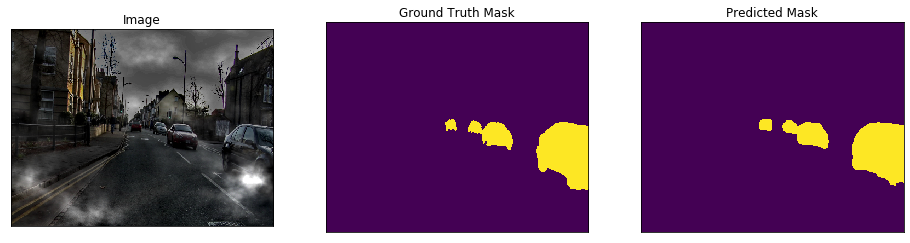

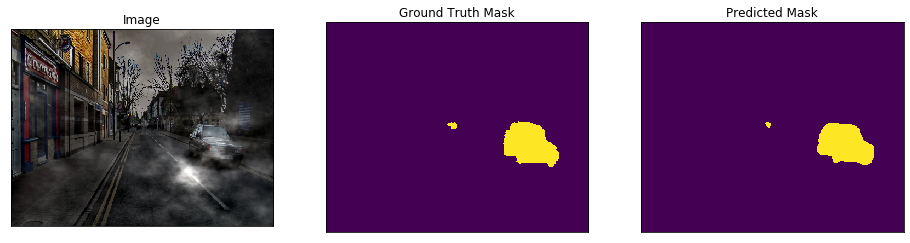

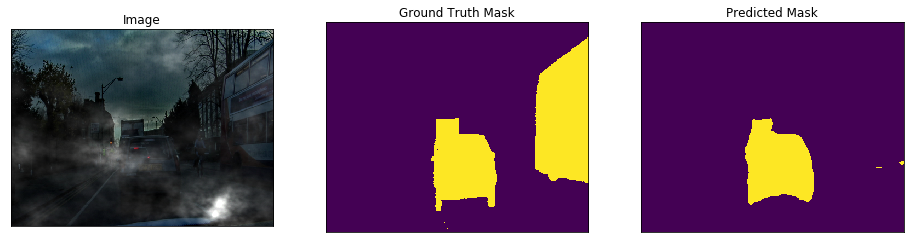

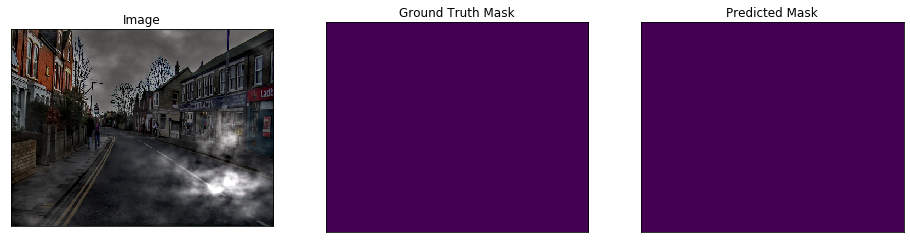

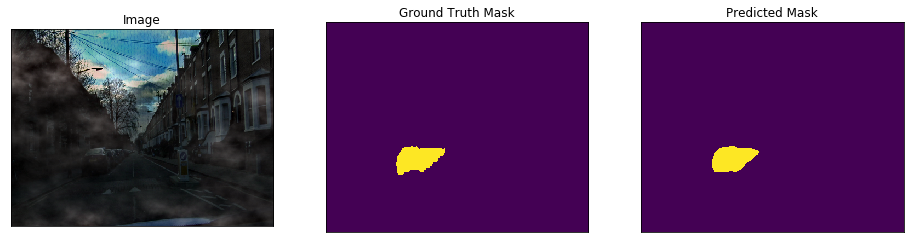

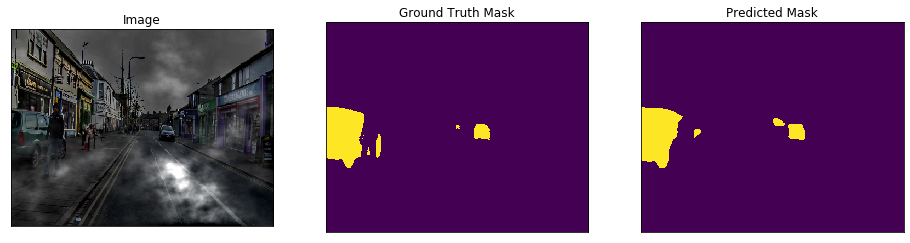

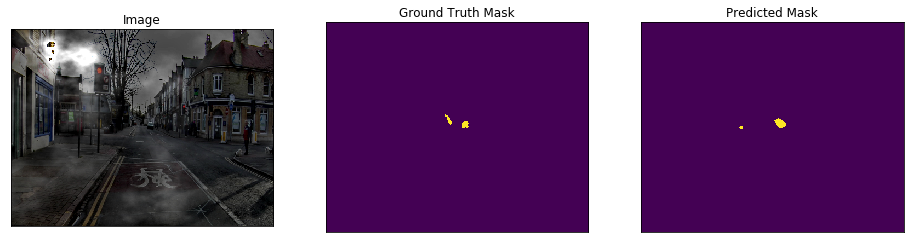

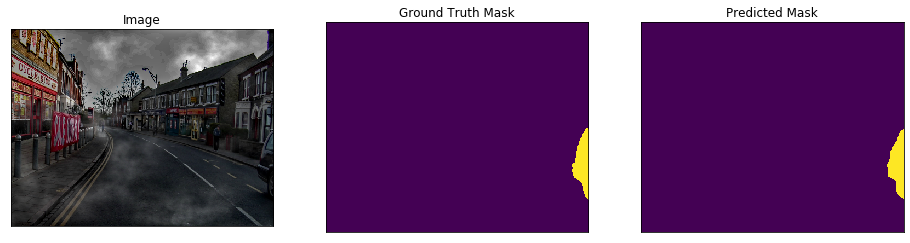

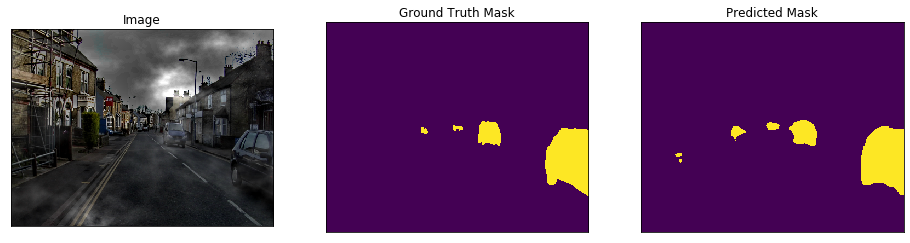

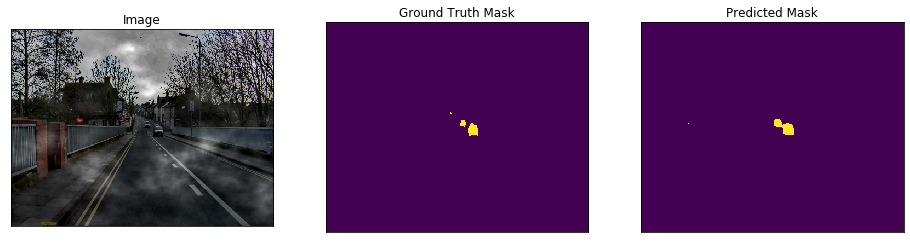

In [29]:
for i in range(10):
    n = np.random.choice(len(test_dcp_dataset))
    image_vis = test_dcp_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dcp_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

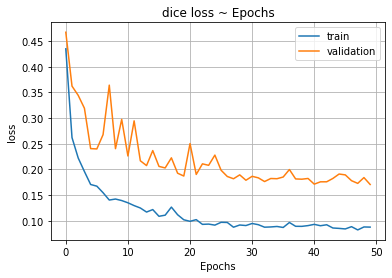

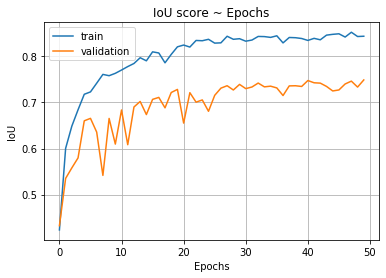

In [28]:
# Graphs

x = range(epochs)

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))
plt.plot(x, dice_loss_train, label = 'train')
plt.plot(x, dice_loss_valid, label = 'validation')
plt.legend()
plt.title("dice loss ~ Epochs")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.grid()
plt.show()
plt.plot(x, iou_score_train, label = 'train')
plt.plot(x, iou_score_valid, label = 'validation')
plt.legend()
plt.title("IoU score ~ Epochs")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.grid()